## NIFTY50 Daily Return Stock and Sector Correlation Analysis

GNU General Public License v3.0

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

# Common Mistakes with Correlation

From : https://www.investopedia.com/ask/answers/031015/how-can-you-calculate-correlation-using-excel.asp

The single most common mistake is assuming a correlation approaching +/- 1 is statistically significant.  A reading approaching +/- 1 definitely increases the chances of actual statistical significance, but without further testing it's impossible to know. The statistical testing of a correlation can get complicated for a number of reasons; it's not at all straightforward.  A critical assumption of correlation is that the variables are independent and that the relationship between them is linear. In theory, you would test these claims to determine if a correlation calculation is appropriate.  

The second most common mistake is forgetting to normalize the data into a common unit.  If calculating a correlation on two betas, then the units are already normalized: beta itself is the unit.  However, if you want to correlate stocks, it's critical you normalize them into percent return, and not share price changes.  This happens all too frequently, even among investment professionals.  

For stock price correlation, you are essentially asking two questions: What is the return over a certain number of periods, and how does that return correlate to another security's return over the same period?  This is also why correlating stock prices is difficult: Two securities might have a high correlation if the return is daily percent changes over the past 52 weeks, but a low correlation if the return is monthly changes over the past 52 weeks.  Which one is "better"? There really is no perfect answer, and it depends on the purpose of the test. 

For pairs trading, we need co-integration, not correlation.

## Imports

In [2]:
import numpy as np
import pandas as pd

import datetime
from datetime import date, timedelta

from nsepy import get_history

import seaborn as sns
import matplotlib.pyplot as plt

import os

# Stock wise coorelation

In [3]:
#ending date for stock price fetching
end_date = date.today()

#Calculate date 52 weeks prior to today
start_date = end_date - timedelta(52*7)

In [4]:
# NSE provides a handy csv file with all the company names, their stock prices and symbols
# that we can parse to fetch the stock prices

# https://www.nseindia.com/products/content/equities/indices/nifty_next_50.htm
# Every time the ind_nifty50list.csv is updated, the NIFTY_stock_data.csv must be deleted
nifty50 = pd.read_csv('ind_nifty50list.csv')

In [5]:
nifty50.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
1,Asian Paints Ltd.,CONSUMER GOODS,ASIANPAINT,EQ,INE021A01026
2,Axis Bank Ltd.,FINANCIAL SERVICES,AXISBANK,EQ,INE238A01034
3,Bajaj Auto Ltd.,AUTOMOBILE,BAJAJ-AUTO,EQ,INE917I01010
4,Bajaj Finance Ltd.,FINANCIAL SERVICES,BAJFINANCE,EQ,INE296A01024


## Fetch Stock Prces

In [6]:
# if the file does not exist, fetch prices and create it
if not os.path.isfile('NIFTY_stock_data.csv'):
    
    stock_price_dataframe = pd.DataFrame()
    
    for stock in nifty50['Symbol']:
        stock_price_dataframe[stock] = get_history(symbol=stock, start=start_date, end=end_date)['Close']
        
    #change date before saving
    stock_price_dataframe.index = pd.to_datetime(stock_price_dataframe.index, format = '%Y-%m-%d').strftime('%d-%m-%Y')
       
    stock_price_dataframe.to_csv('NIFTY_stock_data.csv', mode='a', sep=',', index_label='Date')

# if the file exists, append new prices till today
else:    
    #Find the date range between which the stock data need to be appended
    temporary_dataframe = pd.read_csv('NIFTY_stock_data.csv', index_col='Date')

    date_str = temporary_dataframe.iloc[-1].name
    format_str = '%d-%m-%Y' # The format

    last_updated_date = datetime.datetime.strptime(date_str, format_str).date()
    today_date = date.today()

    continue_date = last_updated_date + timedelta(1)
    yesterday_date = today_date - timedelta(1)
    
    
    updated_stock_price_dataframe = pd.DataFrame()
    # only download new data if last date is not the same as current date
    if last_updated_date != yesterday_date:
        print('Downloading and updating stock prices from {} to {}.'.format(continue_date, yesterday_date))
        
        for stock in nifty50['Symbol']:
            updated_stock_price_dataframe[stock] = get_history(symbol=stock, start=continue_date, end=yesterday_date)['Close']
        
        # change date before saving
        updated_stock_price_dataframe.index = pd.to_datetime(updated_stock_price_dataframe.index, format = '%Y-%m-%d').strftime('%d-%m-%Y')
        
        updated_stock_price_dataframe.to_csv('NIFTY_stock_data.csv', mode='a', sep=',', header=False)
    else:
        print('Data is current, No update needed')
    
stocks_close_price = pd.read_csv('NIFTY_stock_data.csv')

In [7]:
# Run this for percent change coorelation

# calculate daily percenttage return
for stock in nifty50['Symbol']:
    stocks_close_price[stock] = stocks_close_price[stock].pct_change(1)

In [9]:
stocks_close_price.describe()

# notice the mean return is almost zero

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,-0.000769,0.000453,0.001112,-0.000652,0.001313,0.000686,-0.001966,-0.001727,-0.001735,-0.000525,...,-0.002920,-0.000679,0.001664,0.001463,-0.000184,-0.000505,-0.001651,0.000487,-0.000771,-0.000677
std,0.018885,0.013819,0.019311,0.015684,0.021798,0.018405,0.025942,0.021161,0.017100,0.017401,...,0.021344,0.020543,0.019495,0.021592,0.022085,0.015171,0.023012,0.013099,0.030215,0.014294
min,-0.069833,-0.051608,-0.047065,-0.088411,-0.071519,-0.061981,-0.198852,-0.066247,-0.060912,-0.072558,...,-0.131858,-0.091255,-0.070004,-0.078729,-0.067091,-0.048276,-0.107490,-0.040658,-0.290414,-0.046664
25%,-0.011614,-0.007774,-0.011010,-0.009123,-0.010348,-0.010417,-0.014844,-0.013186,-0.011809,-0.010155,...,-0.012930,-0.013225,-0.010253,-0.009577,-0.013683,-0.009823,-0.013976,-0.005864,-0.010817,-0.010618
50%,-0.000793,-0.000928,-0.000265,-0.000560,0.001377,0.001225,-0.001850,-0.002911,-0.000833,-0.001522,...,-0.002627,0.000541,0.001081,0.000574,-0.001074,-0.000652,-0.002387,0.000388,-0.000442,-0.000645
75%,0.009259,0.007344,0.011056,0.007794,0.011830,0.009963,0.012682,0.007549,0.008796,0.006781,...,0.008204,0.012159,0.013975,0.011348,0.011547,0.010267,0.012085,0.007879,0.011804,0.007835
max,0.073331,0.056459,0.092051,0.053176,0.109655,0.098064,0.066678,0.104757,0.050868,0.076241,...,0.060463,0.063054,0.085827,0.187874,0.150109,0.038410,0.070766,0.053810,0.093656,0.062384


In [10]:
# delete the first row since it has no percentage return data
daily_percent_change = stocks_close_price.iloc[1:]

In [11]:
daily_percent_change.head()

,Date,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
1,31-10-2017,0.001280,-0.001438,0.080888,-0.007647,-0.002051,0.003103,0.009977,0.008724,0.028974,...,-0.018669,-0.020118,-0.007208,0.027414,-0.030446,-0.015920,-0.026690,0.002728,-0.001906,-0.012933
2,01-11-2017,0.006390,-0.004150,0.022842,-0.005327,0.003416,0.002445,-0.003323,0.084272,-0.035282,...,0.021825,0.004973,0.013380,0.003463,-0.021581,0.005737,0.034654,-0.001700,0.014479,-0.011257
3,02-11-2017,0.009582,0.002083,-0.005513,0.000417,0.001910,-0.008054,0.005650,0.007605,-0.018521,...,-0.006511,-0.001697,-0.042068,0.027767,-0.003516,-0.006134,-0.007427,-0.001022,0.005176,-0.012225
4,03-11-2017,-0.005489,-0.005049,0.014939,-0.007297,0.014777,0.010126,-0.017961,-0.003590,-0.011704,...,0.029432,0.003965,-0.009616,0.007021,-0.004748,-0.005467,-0.007923,0.004433,0.017163,0.018328
5,06-11-2017,0.006209,-0.008614,-0.010368,-0.002362,-0.008138,-0.004570,-0.016695,-0.016074,0.024894,...,0.033951,-0.002962,-0.006473,0.187874,-0.017664,0.012034,0.002366,0.017994,-0.019328,-0.015493


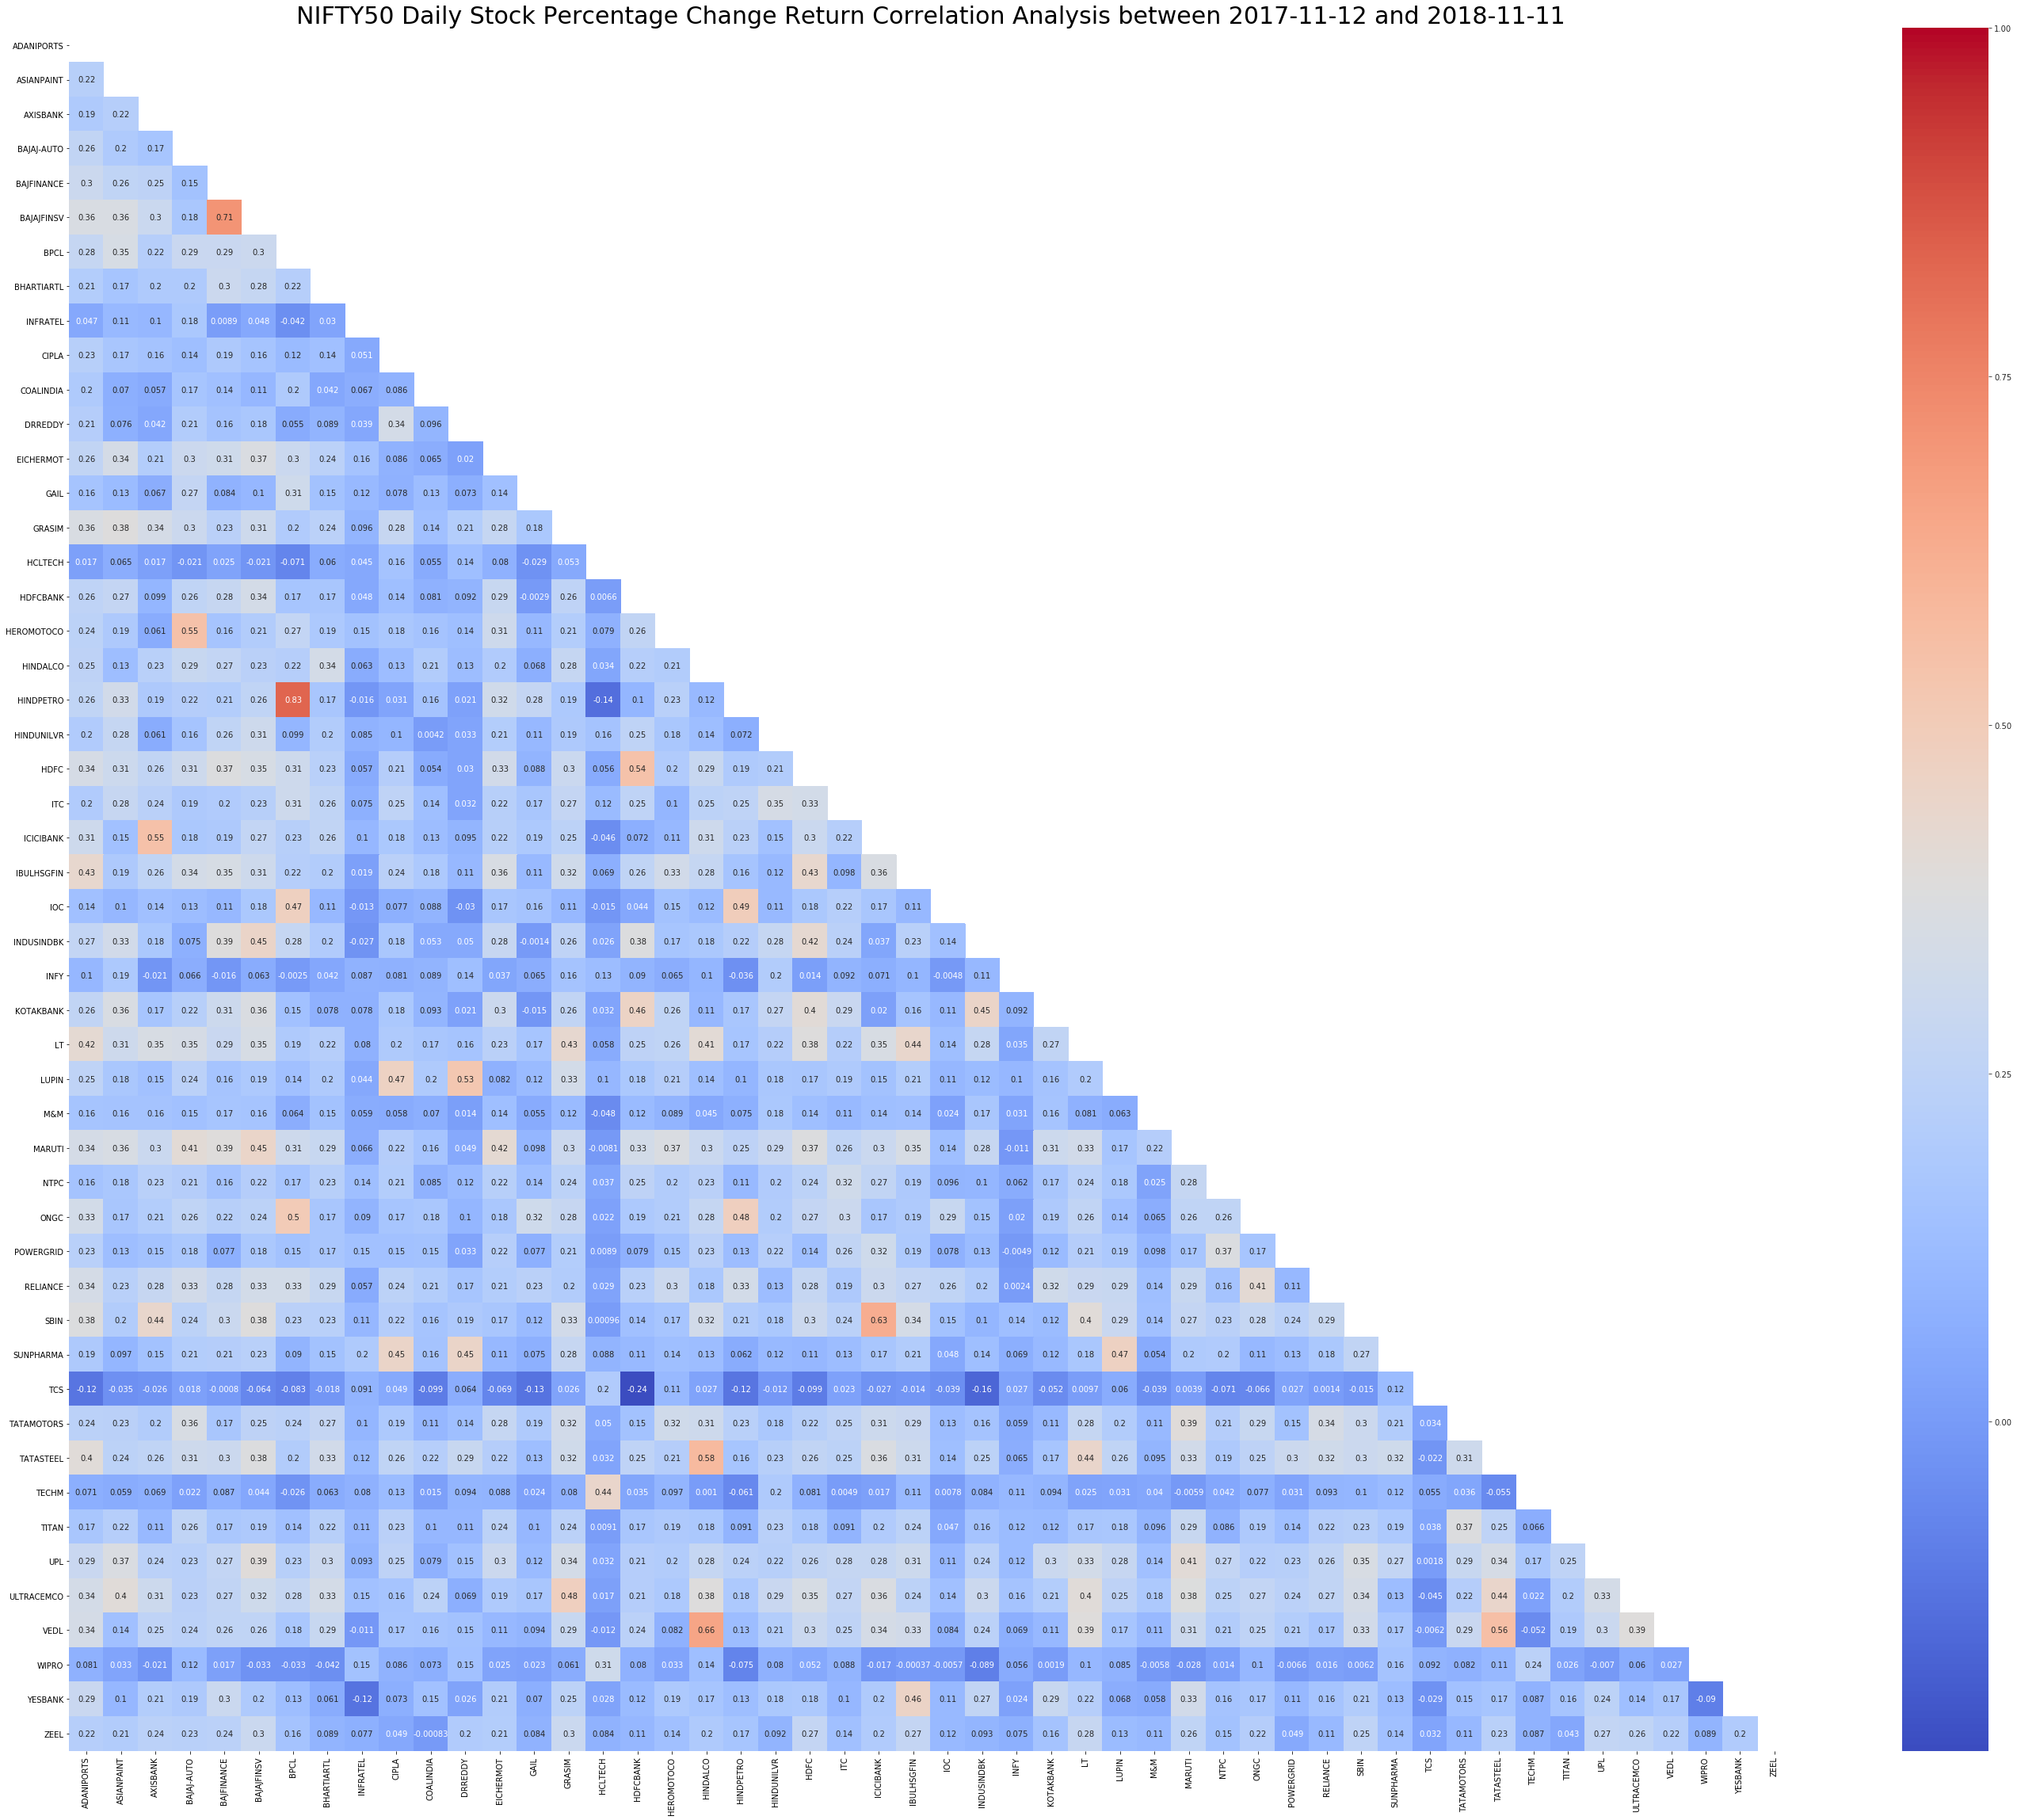

In [12]:
fig, ax = plt.subplots(figsize=(50,40)) # figsize in inches

ax.set_title("NIFTY50 Daily Stock Percentage Change Return Correlation Analysis between {start} and {end}".format(start=start_date, end=end_date), fontsize=30)

# create a mask to cull upper diagonal half of the matrix since its a mirror image of lower diagonal half 
mask = np.zeros_like(daily_percent_change.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(daily_percent_change.corr(), annot=True, cmap="coolwarm", mask=mask, square=True)

fig.savefig("NIFTY50CorrelationMatrix.png", dpi=300)

In [14]:
# visualize the mask for debugging purposes
#mask

# Sector wise correlation

In [15]:
# Find the indsustries that comprise of NIFTY50
nifty50['Industry'].unique()

array(['SERVICES', 'CONSUMER GOODS', 'FINANCIAL SERVICES', 'AUTOMOBILE',
       'ENERGY', 'TELECOM', 'PHARMA', 'METALS',
       'CEMENT & CEMENT PRODUCTS', 'IT', 'CONSTRUCTION',
       'FERTILISERS & PESTICIDES', 'MEDIA & ENTERTAINMENT'], dtype=object)

In [16]:
# create daily percentage change retrun for each industry

industry_data_frame = pd.DataFrame()

for industry in nifty50['Industry'].unique():
    # create a filter for the industry
    filter_symbol = nifty50['Industry'] == industry
    
    # get all the symbols for that industry
    industry_symbols = nifty50[filter_symbol]['Symbol']
    
    # get all the stock prices for that industry in one dataframe
    industry_stocks_percent_change = daily_percent_change.loc[:, industry_symbols]
    
    # create a sum column and add the returns by all companies in that industry per day
    industry_stocks_percent_change['Sum'] = industry_stocks_percent_change.sum(axis=1)
    
    # add each industry's return to a column in a dataframe
    industry_data_frame[industry] = industry_stocks_percent_change['Sum']

In [17]:
print(industry_data_frame.head())

   SERVICES  CONSUMER GOODS  FINANCIAL SERVICES  AUTOMOBILE    ENERGY  \
1  0.001280        0.030684            0.042710   -0.045993 -0.018336   
2  0.006390        0.031540            0.177884   -0.024148 -0.000605   
3  0.009582        0.001170           -0.034855   -0.034078  0.010369   
4 -0.005489       -0.000580            0.117496    0.008426 -0.031854   
5  0.006209        0.178263           -0.037794    0.064485 -0.031202   

    TELECOM    PHARMA    METALS  CEMENT & CEMENT PRODUCTS        IT  \
1  0.037698 -0.000083 -0.076519                  0.008028 -0.001810   
2  0.048990 -0.039309  0.069520                  0.022199 -0.008442   
3 -0.010915  0.098180 -0.009242                  0.030866 -0.018095   
4 -0.015294 -0.024827 -0.026942                 -0.009758 -0.015954   
5  0.008820 -0.018917  0.013767                  0.011025  0.028600   

   CONSTRUCTION  FERTILISERS & PESTICIDES  MEDIA & ENTERTAINMENT  
1     -0.011844                 -0.030446              -0.012933  


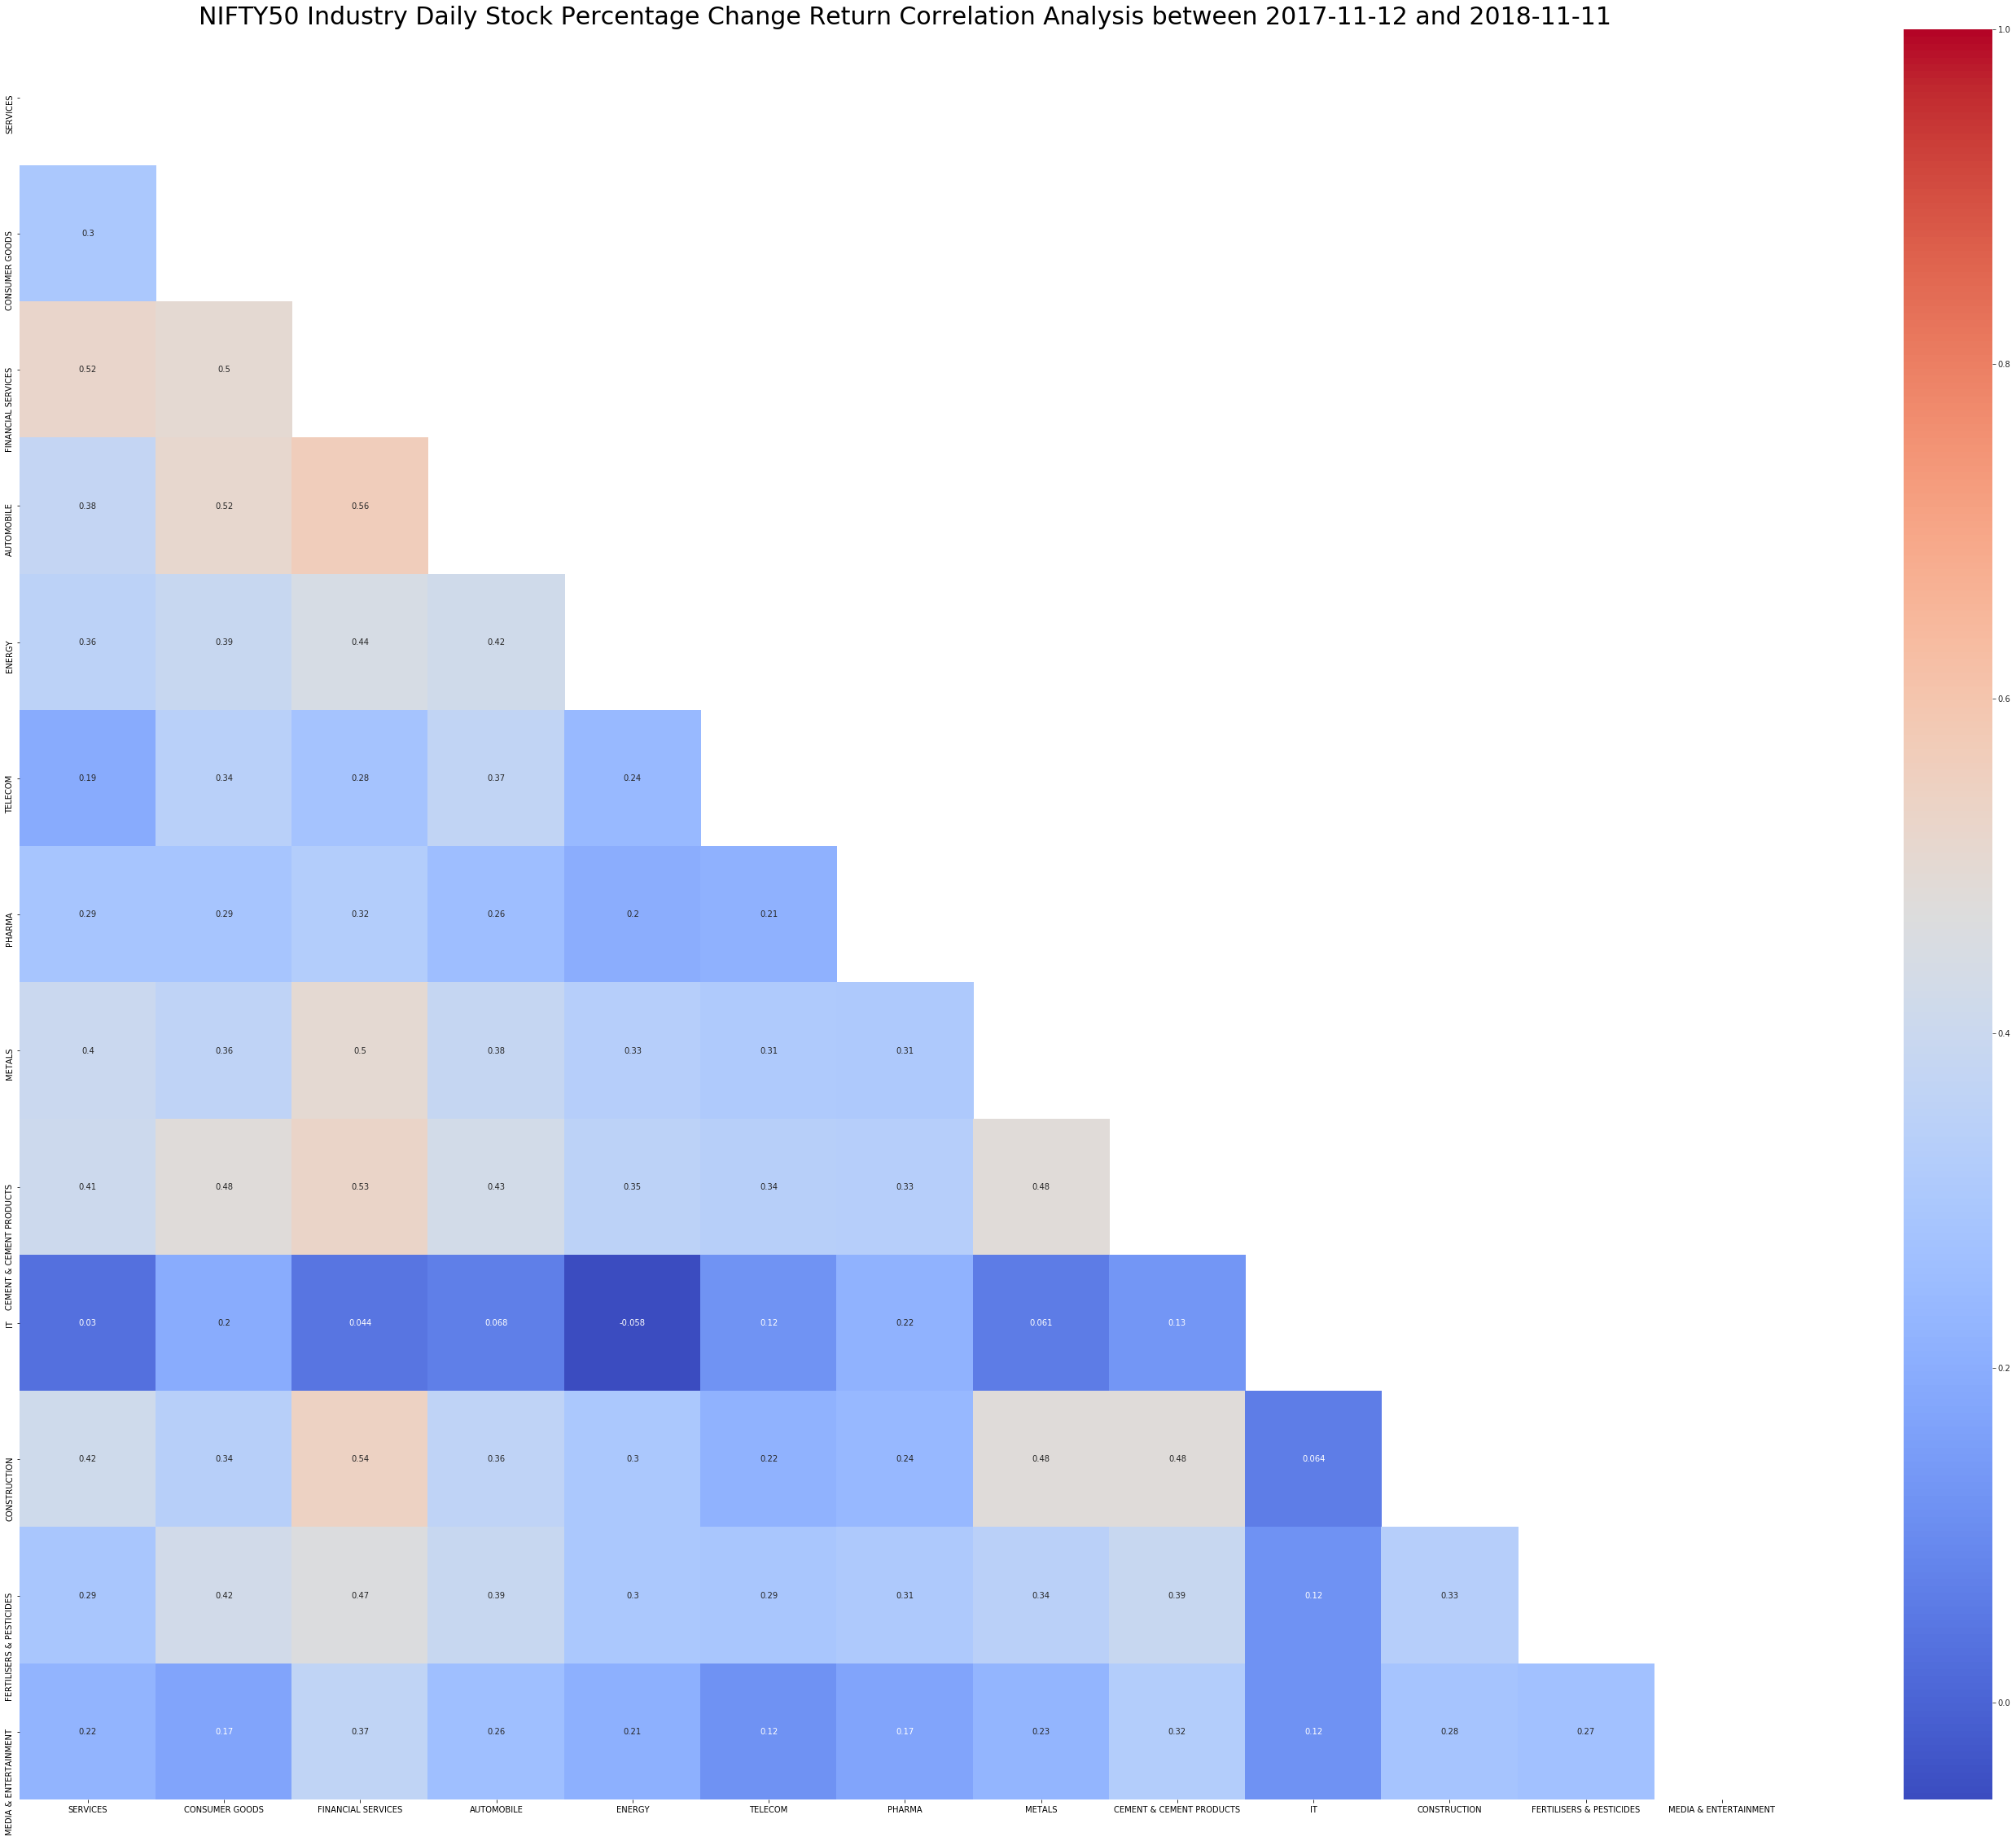

In [18]:
fig, ax = plt.subplots(figsize=(50,40)) # figsize in inches

ax.set_title("NIFTY50 Industry Daily Stock Percentage Change Return Correlation Analysis between {start} and {end}".format(start=start_date, end=end_date), fontsize=30)

mask = np.zeros_like(industry_data_frame.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(industry_data_frame.corr(), annot=True, cmap="coolwarm", mask=mask, square=True)

fig.savefig("NIFTY50IndustryCorrelationMatrix.png", dpi=300)